In [1]:
#from __future__ import absolute_import
from pathlib import Path
import os, sys, json
import cv2
import numpy as np
import random
import torch
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, StepLR
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation import deeplabv3_resnet101
import cleanfid 
from tqdm import trange
from omegaconf import OmegaConf

here_dir = '.'

sys.path.append(os.path.join(here_dir, 'src'))


from models import BlobGAN, load_model
from models import DecisionDensenetModel, DecisionExplainDensenetModel
from models.networks import StyleGANDiscriminator
from utils import download_model, download_mean_latent, download_cherrypicked, KLD_COLORS, BED_CONF_COLORS, \
    viz_score_fn, for_canvas, draw_labels, HtmlPageVisualizer
from data import BDDDataset
import models
from data.utils import CustomImageDataset, BDDOIADataset, LABELS

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/memory.py:16: LightningDeprecationWarning: `pytorch_lightning.core.memory.get_memory_profile` and `pytorch_lightning.core.memory.get_gpu_memory_map` have been moved to `pytorch_lightning.utilities.memory` since v1.5 and will be removed in v1.7.
  rank_zero_deprecation(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/memory.py:25: LightningDeprecationWarning: `pytorch_lightning.core.memory.LayerSummary` and `pytorch_lightning.core.memory.ModelSummary` have been moved to `pytorch_lightning.utilities.model_summary` since v1.5 and will be removed in v1.7.
  rank_zero_deprecation(


In [2]:
device = torch.device("cuda:0") #"cuda:0" "cpu"
torch.cuda.set_device(device)

In [3]:
# BlobGan square
ckpt = 'checkpoints/blobgan_256x256.ckpt'
# BlobGan rect
ckpt = 'checkpoints/blobgan_256x512.ckpt'
model = load_model(ckpt, device)

Froze 79 parameters - ['conv1.conv', 'conv1.noise', 'conv1.activate', 'to_rgb1', 'to_rgb1.conv', 'convs.0', 'convs.1', 'convs.2', 'convs.3', 'convs.4', 'convs.5', 'convs.6', 'convs.7', 'convs.8', 'convs.9', 'to_rgbs.0', 'to_rgbs.1', 'to_rgbs.2', 'to_rgbs.3', 'to_rgbs.4'] - for model of type LayoutStyleGANGenerator
Froze 16 parameters - ['mlp.1', 'mlp.2', 'mlp.3', 'mlp.4', 'mlp.5', 'mlp.6', 'mlp.7', 'mlp.8'] - for model of type LayoutGenerator
Done loading and configuring model!


Computing mean latent: 100%|██████████| 10000/10000 [00:11<00:00, 839.72it/s]


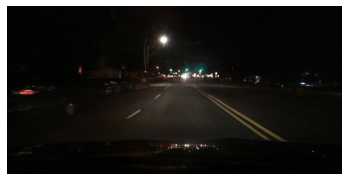

In [4]:
z = torch.randn((1, 512)).to(device)
truncate = 0.4
layout, orig_img = model.gen(z=z, truncate=truncate, **model.render_kwargs)

img = for_canvas(orig_img)
blob = for_canvas(layout['feature_img'].mul(255))

plt.axis('off')
plt.imshow(img)

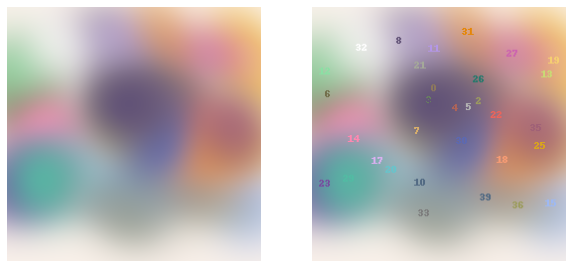

In [6]:
labeled_blobs, labeled_blobs_img = draw_labels(blob, layout, -2, KLD_COLORS)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
ax0, ax1 = axes.flatten()

ax0.axis('off')
ax1.axis('off')

ax0.imshow(blob)
ax1.imshow(labeled_blobs_img)

In [42]:
mlp_idx = -1

noise = model.layout_net_ema.mlp[:mlp_idx](z)
noise = (model.mean_latent * truncate) + (noise * (1 - truncate))
metadata = model.layout_net_ema(noise, 40, mlp_idx)

In [45]:
for k,v in metadata.items():
    print(f'{k}: {v.size()}')
indices = torch.topk(metadata['sizes'][0],10).indices
print(f'Main blobs: {indices}')
metadata['sizes'][0,30] = 1

xs: torch.Size([1, 40])
ys: torch.Size([1, 40])
sizes: torch.Size([1, 41])
covs: torch.Size([1, 40, 4])
features: torch.Size([1, 41, 256])
spatial_style: torch.Size([1, 41, 256])
Main blobs: tensor([30, 19, 39,  0, 15, 16, 31, 24, 28, 14], device='cuda:0')


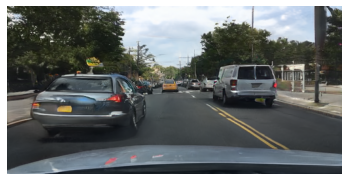

In [46]:
layout, orig_img = model.gen(layout=metadata, truncate=truncate, **model.render_kwargs)

img = for_canvas(orig_img)
blob = for_canvas(layout['feature_img'].mul(255))
plt.axis('off')
plt.imshow(img)

### Encoder

In [5]:
# BlobGan square
encoder_path = 'checkpoints/encoder_256x256.pt'
# BlobGan rect
encoder_path = 'checkpoints/encoder_256x512.pt'

In [6]:
aspect_ratio = model.generator_ema.aspect_ratio
resolution = model.resolution
# Encoder
encoder = StyleGANDiscriminator(size = resolution,
                                    discriminate_stddev = False,
                                    d_out=model.layout_net_ema.mlp[-1].weight.shape[1],
                                    aspect_ratio = aspect_ratio).to(device) 
encoder.load_state_dict(torch.load(encoder_path)['model']) 
encoder = encoder.eval()
 

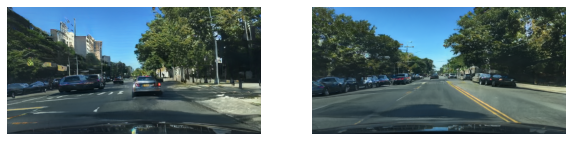

In [19]:
z = torch.randn((1, 512)).to(device)
truncate = 0.2

with torch.no_grad():
    orig_img = model.gen(z=z, ema=True, truncate=truncate, no_jitter=True)
    z_pred_fake = encoder(orig_img)
    layout_pred_fake, reconstr_fake = model.gen(z=z_pred_fake, mlp_idx=-1, **model.render_kwargs)
    orig_img= orig_img.add_(1).div_(2).mul_(255)

orig_img = for_canvas(orig_img)
reconstr_fake = for_canvas(reconstr_fake)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
ax0, ax1 = axes.flatten()
ax0.axis('off')
ax1.axis('off')
ax0.imshow(orig_img)
ax1.imshow(reconstr_fake)

### Inversion [optim]

For rectangular model only

In [20]:
inversions = torch.load('shared_files/validation_rec.pt')
dataset_path = '/datasets_local/BDD/bdd100k/seg/images/val'


Text(0.5, 1.0, 'Reconstructed iamege')

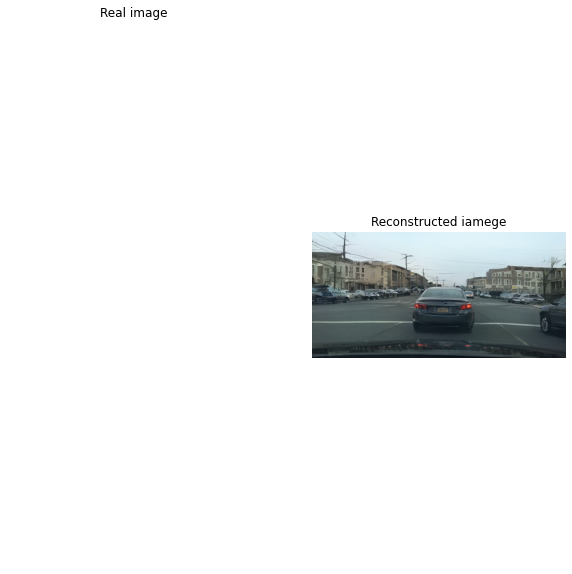

In [6]:
i = random.randint(0, len(inversions))
image_name = list(inversions.keys())[i]
blobs = list(inversions.values())[i]

layout, img_rec =  model.gen(layout=blobs, **model.render_kwargs)
real_img= Image.open(os.path.join(dataset_path,image_name))

img_rec = for_canvas(img_rec)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
ax0, ax1 = axes.flatten()
ax0.axis('off')
ax1.axis('off')
ax0.imshow(real_img)
ax0.set_title('Real image')
ax1.imshow(img_rec)
ax1.set_title('Reconstructed iamege')


In [ ]:
config = 'checkpoints/sem_seg/sem_seg/deeplabv3_r50-d8_769x769_40k_sem_seg_bdd100k.py'
ckpt = 'checkpoints/sem_seg/deeplabv3_r50-d8_512x1024_80k_sem_seg_bdd100k.pth'

In [ ]:
CLASSES = (
    "road",
    "sidewalk",
    "building",
    "wall",
    "fence",
    "pole",
    "traffic light",
    "traffic sign",
    "vegetation",
    "terrain",
    "sky",
    "person",
    "rider",
    "car",
    "truck",
    "bus",
    "train",
    "motorcycle",
    "bicycle",
)

PALETTE = [
    [128, 64, 128],
    [244, 35, 232],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [70, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
]

In [ ]:
import mmcv
from mmseg.models import build_segmentor
import mmcv
import torch
from mmcv.runner import (
    load_checkpoint,
    wrap_fp16_model,
)
from mmseg.models import build_segmentor
cfg = mmcv.Config.fromfile(config)
cfg.load_from = ckpt
segmentation_model = build_segmentor(cfg.model, test_cfg=cfg.get("test_cfg")).eval().cuda()

checkpoint = load_checkpoint(segmentation_model, cfg.load_from, map_location="cpu")
if "CLASSES" in checkpoint.get("meta", {}):
    segmentation_model.CLASSES = checkpoint["meta"]["CLASSES"]
else:
    print("'CLASSES' not found in meta, use dataset.CLASSES instead")
    segmentation_model.CLASSES = CLASSES
if "PALETTE" in checkpoint.get("meta", {}):
    segmentation_model.PALETTE = checkpoint["meta"]["PALETTE"]
else:
    print("'PALETTE' not found in meta, use dataset.PALETTE instead")
    segmentation_model.PALETTE = PALETTE

In [ ]:
result = segmentation_model([orig_img_], img_metas, return_loss=False)[0]

In [ ]:
np.unique(result)

In [ ]:
prediction_colormap = decode_segmentation_masks(result, colormap)
overlay = cv2.addWeighted(img, 0.25, prediction_colormap, 0.75, 0)
plt.imshow(overlay)

In [ ]:
cfg = 'checkpoints/panoptic/pan_seg/panoptic_fpn_r101_fpn_5x_pan_seg_bdd100k.py'
checkpoint = 'checkpoints/panoptic/panoptic_fpn_r101_fpn_5x_pan_seg_bdd100k.pth'
pano_model = init_detector(cfg, checkpoint, device='cuda')

In [ ]:
z = torch.randn((1, 512)).to(device)
truncate = 0.3
layout, orig_img = model.gen(z=z, truncate=truncate, **model.render_kwargs)

img = for_canvas(orig_img)
blob = for_canvas(layout['feature_img'].mul(255))
plt.axis('off')
plt.imshow(img)

In [ ]:
result = inference_detector(pano_model, img)['pan_results']

In [ ]:
colormap = KLD_COLORS.numpy()
colormap = colormap * 100
colormap = colormap.astype(np.uint8)
def decode_segmentation_masks(mask, colormap):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    classes = [0,1,2] 
    classes = np.unique(mask)
    classes = list(range(19))
    for i, cl in enumerate(classes):
        idx = mask == cl
        r[idx] = colormap[i, 0]
        g[idx] = colormap[i, 1]
        b[idx] = colormap[i, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [ ]:
np.unique(result)

In [ ]:
prediction_colormap = decode_segmentation_masks(result, colormap)
overlay = cv2.addWeighted(img, 0.25, prediction_colormap, 0.75, 0)
plt.imshow(overlay)

In [ ]:
plt.imshow(prediction_colormap)

In [ ]:
config = 'checkpoints/drivable/drivable/deeplabv3_r101-d8_512x1024_80k_drivable_bdd100k.py'
ckpt = 'checkpoints/drivable/deeplabv3_r101-d8_512x1024_80k_drivable_bdd100k.pth'
#det_model = init_detector(config, checkpoint, device='cuda')

In [ ]:
import mmcv
from mmseg.models import build_segmentor
import mmcv
import torch
from mmcv.runner import (
    load_checkpoint,
    wrap_fp16_model,
)
from mmseg.models import build_segmentor
CLASSES = ("direct", "alternative", "background")
PALETTE = [[219, 94, 86], [86, 211, 219], [0, 0, 0]]
cfg = mmcv.Config.fromfile(config)
cfg.load_from = ckpt
drivable_model = build_segmentor(cfg.model, test_cfg=cfg.get("test_cfg")).eval().cuda()
#fp16_cfg = cfg.get("fp16", None)
#if fp16_cfg is not None:
#    wrap_fp16_model(drivable_model)
checkpoint = load_checkpoint(drivable_model, cfg.load_from, map_location="cpu")
if "CLASSES" in checkpoint.get("meta", {}):
    drivable_model.CLASSES = checkpoint["meta"]["CLASSES"]
else:
    print("'CLASSES' not found in meta, use dataset.CLASSES instead")
    drivable_model.CLASSES = CLASSES
if "PALETTE" in checkpoint.get("meta", {}):
    drivable_model.PALETTE = checkpoint["meta"]["PALETTE"]
else:
    print("'PALETTE' not found in meta, use dataset.PALETTE instead")
    drivable_model.PALETTE = PALETTE

In [ ]:
_img_metas = {
    'ori_shape': (256, 512, 3),
    'img_shape': (256, 512, 3),
    'pad_shape': (256, 512, 3),
    'scale_factor': [1., 1., 1., 1.],
    'flip': False,
    'flip_direction': 'horizontal',
    'img_norm_cfg': {
        'mean': [123.675, 116.28 , 103.53 ],
        'std': [58.395, 57.12 , 57.375],
        'to_rgb': True
    },
    'batch_input_shape': (256, 512, 3)
    }

img_metas = [[_img_metas]]

In [ ]:
z = torch.randn((1, 512)).to(device)
truncate = 0.4
layout, orig_img = model.gen(z=z, truncate=truncate, **model.render_kwargs)

img = for_canvas(orig_img)
blob = for_canvas(layout['feature_img'].mul(255))
plt.axis('off')
plt.imshow(img)

In [ ]:
import torchvision
orig_img_ = torchvision.transforms.functional.normalize(orig_img, mean=[123.675, 116.28 , 103.53 ], std=[58.395, 57.12 , 57.375])

In [ ]:
seg_logit = drivable_model.forward_dummy(orig_img_.requires_grad_(True))
seg_pred = seg_logit.argmax(dim=1)
seg_pred.shape

In [ ]:
result = drivable_model([orig_img_], img_metas, return_loss=False)

In [ ]:
target_mask = torch.nn.functional.one_hot(seg_pred[0].cpu()).permute(2,0,1)
target_mask[0,:200,:] = 0
target_mask[0,:,180:] = 0
#target_mask[2,:,180:] = 1
target_mask[2,:200,:] = 1
target_mask = target_mask.argmax(0).type(torch.LongTensor).unsqueeze(0)
print(target_mask.shape)

In [ ]:
target_mask = seg_pred[0].cpu().unsqueeze(0).type(torch.LongTensor)
mask = target_mask==1
#mask[:,170:,280:] = 0
mask[:,:,280:] = 0
target_mask[mask] = 2

In [ ]:
plt.imshow(mask.numpy()[0])

In [ ]:
plt.axis('off')
plt.imshow(target_mask.numpy()[0])

In [ ]:
def generate_layout_feat(z, truncate=None, mlp_idx=None):
  num_features = random.randint(model.n_features_min, model.n_features_max)
  if truncate is not None:
    mlp_idx = -1
    z = model.layout_net_ema.mlp[:mlp_idx](z)
    z = (model.mean_latent * truncate) + (z * (1 - truncate))
  return model.layout_net_ema(z, num_features, mlp_idx)

def opt_var(params, target_params=None, target_blobs=None):
  opt_params = {}
  req_grad = False
  for key, val in params.items():
    if target_params is not None:
      req_grad = (key in target_params)
    opt_params[key] = val.clone().detach().requires_grad_(req_grad)
  return opt_params

def _get_tensor_value(tensor):
  """Gets the value of a torch Tensor."""
  return torch.round(tensor.cpu().detach().squeeze(), decimals=4).numpy()

In [ ]:
layout_metadat_orig = generate_layout_feat(z, truncate=0.4)
target_features = ['xs', 'ys', 'sizes', 'covs', 'features', 'spatial_style']
learning_rate = 0.05
n_iters = 100
lr = {'xs':learning_rate/8, 'ys':learning_rate/8, 'sizes':learning_rate,
    'covs':learning_rate, 'features':learning_rate/8, 'spatial_style':learning_rate/8} #/5 /5 /1 /10
λ_prox = 0.1
λs = {'xs':10, 'ys':10, 'sizes':1, 'covs':1, 'features':1, 'spatial_style':1}
criterion = torch.nn.CrossEntropyLoss()
criterion_prox = torch.nn.L1Loss() #torch.nn.MSELoss()

layout_metadat_opt = opt_var(layout_metadat_orig, target_params=target_features)
params = []
for key, val in layout_metadat_opt.items():
    if key in target_features:
        params.append({'params':val, 'lr':lr[key]})
optimizer = torch.optim.Adam(params, lr=learning_rate)
pbar = tqdm(range(1, n_iters + 1), leave=True)#, desc=f'Image {i}')
for step in pbar:
    latout, img =  model.gen(layout=layout_metadat_opt, **model.render_kwargs)
    img_norm = torchvision.transforms.functional.normalize(img, mean=[123.675, 116.28 , 103.53 ], std=[58.395, 57.12 , 57.375])
    seg_logit = drivable_model.forward_dummy(img_norm)
    seg_loss = criterion(seg_logit, target_mask.cuda())
    log_message = f'L_decision: {_get_tensor_value(seg_loss).mean():.4f}'
    
    loss_prox = 0
    for (k_opt, v_opt), (k_orig, v_orig) in zip(layout_metadat_opt.items(), layout_metadat_orig.items()):
        λ = λs.get(k_opt, 0)
        loss_prox += λ * criterion_prox(v_opt,v_orig)
    log_message += f', L_prox: {_get_tensor_value(loss_prox).mean():.4f}'
    pbar.set_description_str(log_message)
    loss = (seg_loss + λ_prox * loss_prox).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step(lambda: loss)

In [ ]:
img = for_canvas(img.detach())
plt.axis('off')
plt.imshow(img)

In [ ]:
prediction_colormap = decode_segmentation_masks(seg_logit.argmax(dim=1).cpu().numpy()[0], np.array(drivable_model.PALETTE))
overlay = cv2.addWeighted(img, 0.8, prediction_colormap, 0.2, 0)
plt.axis('off')
plt.imshow(overlay)

In [ ]:
prediction_colormap = decode_segmentation_masks(result[0], np.array(drivable_model.PALETTE))
overlay = cv2.addWeighted(img, 0.7, prediction_colormap, 0.3, 0)
plt.axis('off')
plt.imshow(overlay)